# **Customer Segmentation Notebook Showing Modeling Using DBSCAN**

## In this notebook, also just like the others, we will conclude our customer segmentation with our last clustering method in DBSCAN.  We will use again our initial scaled dataframe to iterate on, and see once again the differences this clustering method has in store before we draw conclusions on which is best for this project.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import product

In [2]:
random_state = 42
np.random.seed(random_state)

#### Let's once again read in our initial dataframe so we can begin to work with it, making sure to get a fresh look at it and see there's no issues before we start.

In [3]:
df_user_scaled = pd.read_csv(f'/Users/ryanm/Desktop/df-user-scaled.csv')


print(df_user_scaled.shape)
print(df_user_scaled.columns)
print(df_user_scaled.head())
print(df_user_scaled.isna().sum())

dbscan_scaled = df_user_scaled

(206209, 4)
Index(['order_dow_mean', 'order_hour_of_day_mean', 'time_between_purchases',
       'purchase_frequency'],
      dtype='object')
   order_dow_mean  order_hour_of_day_mean  time_between_purchases  \
0       -0.269018               -1.557111                0.764202   
1       -0.648385               -1.428500                0.110680   
2       -1.773842                1.341157               -0.396789   
3        2.174108               -0.467299               -0.188850   
4       -1.065689                1.143728               -0.266827   

   purchase_frequency  
0           -0.695052  
1           -0.392752  
2           -0.037030  
3           -0.200532  
4           -0.142563  
order_dow_mean            0
order_hour_of_day_mean    0
time_between_purchases    0
purchase_frequency        0
dtype: int64


#### This data has already been scaled using StandardScaler, which is also appropriate for DBSCAN.  We will leave it so to promote consistency across all of our clustering methods.  PCA has also been applied to n_components = 2, however we will do so again so we can reacquire a key variable in our pca_features that we will use often here in this notebook.

In [4]:
n_components = 2
pca_fit = PCA(n_components=n_components)
pca_features = pca_fit.fit_transform(dbscan_scaled)

#### DBSCAN works a little differently than some of the other clustering methods, we first have to find the optimal eps value using a K-distance graph.  We will then optimize it as we move along the analysis.  The eps value is crucial as it is a very sensitive parameter but is paramount in determining the outcome of the clustering.

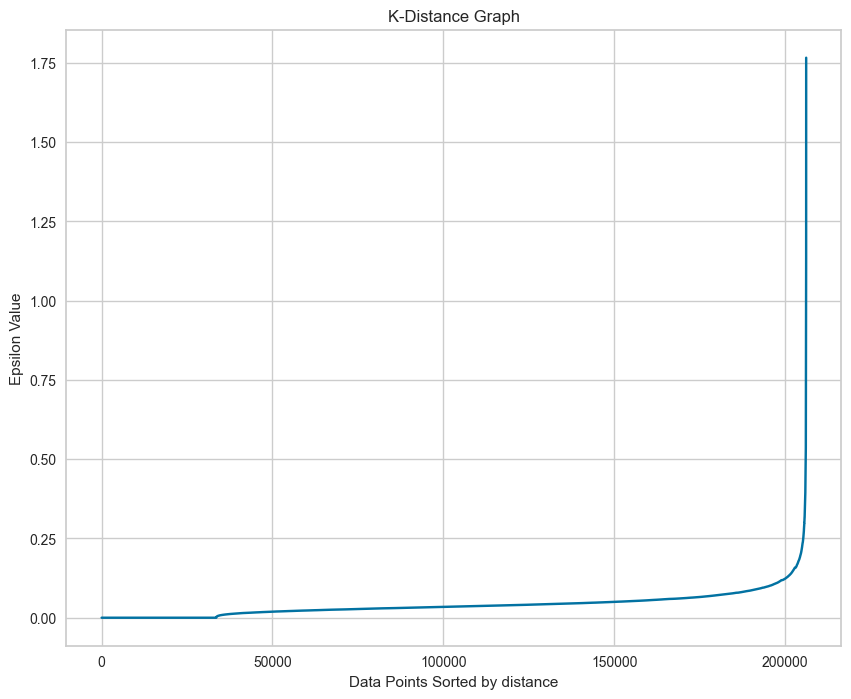

In [5]:
def plot_k_distance_graph(data, n_neighbors):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis = 0)
    distances = distances[:, 1]
    plt.figure(figsize = (10,8))
    plt.plot(distances)
    plt.title('K-Distance Graph')
    plt.xlabel('Data Points Sorted by distance')
    plt.ylabel('Epsilon Value')
    plt.show()

min_samples_init = 5
plot_k_distance_graph(dbscan_scaled, n_neighbors=min_samples_init)


#### Looking at the plot above, we are looking for the point where the elbow starts to curve or 'steepen'.  That mark is on the y-axis of 0.2 for this plot.

#### Before we get too into the DBSCAN analysis let's do a quick visual plot of our data to see the density, this is very important with DBSCAN and will give us and idea on where we need to set the range of our parameters.  As we have done in our Agglomerative Clustering Notebook we will be sampling our dataframe to avoid memory issues.  We will keep the same sampling size for consistency purposes.

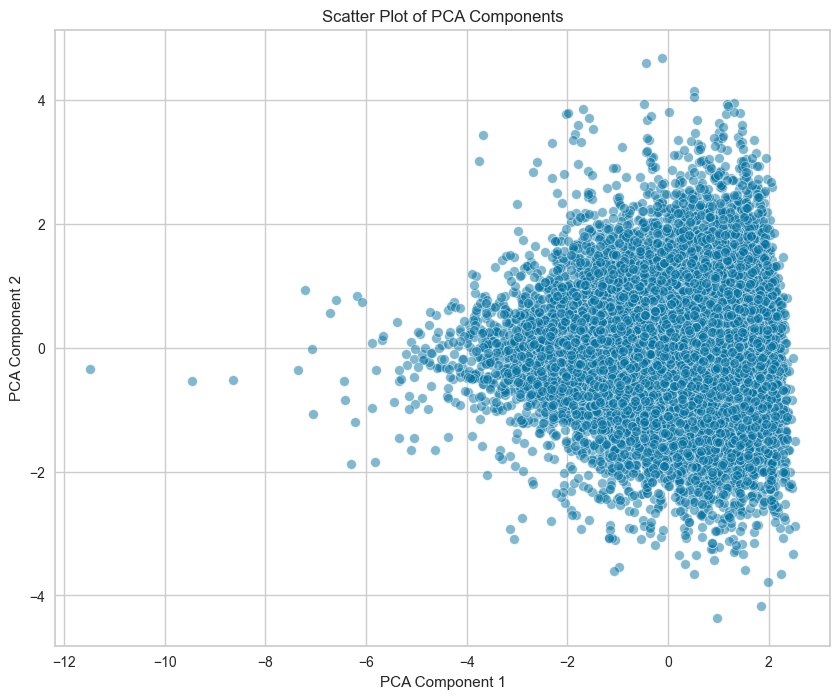

In [10]:
sample_size = 15000
sample_indices = np.random.choice(len(dbscan_scaled), size=sample_size, replace=False)
dbscan_scaled_sampled = dbscan_scaled.iloc[sample_indices]

pca_sampled = PCA(n_components=2)
pca_features_sampled = pca_sampled.fit_transform(dbscan_scaled_sampled)

plt.figure(figsize = (10,8))
sns.scatterplot(x = pca_features_sampled[:,0], y = pca_features_sampled[:, 1], alpha = 0.5)
plt.title("Scatter Plot of PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

#### In DBSCAN it is crucial to cut through the noise and density to be able to see your clusters.  In the above at least for this clustering method it is problematic as of this point we can't see but one cluster.  We will need to fine-tune our parameters for eps and min_samples.

#### Before continuing on to the silhouette plots and analysis of this notebook let's first optimize our DBSCAN parameters to make sure they are accurate.  At this time we will also calculate and add in as output the silhouette scores.

Best eps: 0.02, Best min_samples: 1 with Silhouette Score: 0.24250013086140734


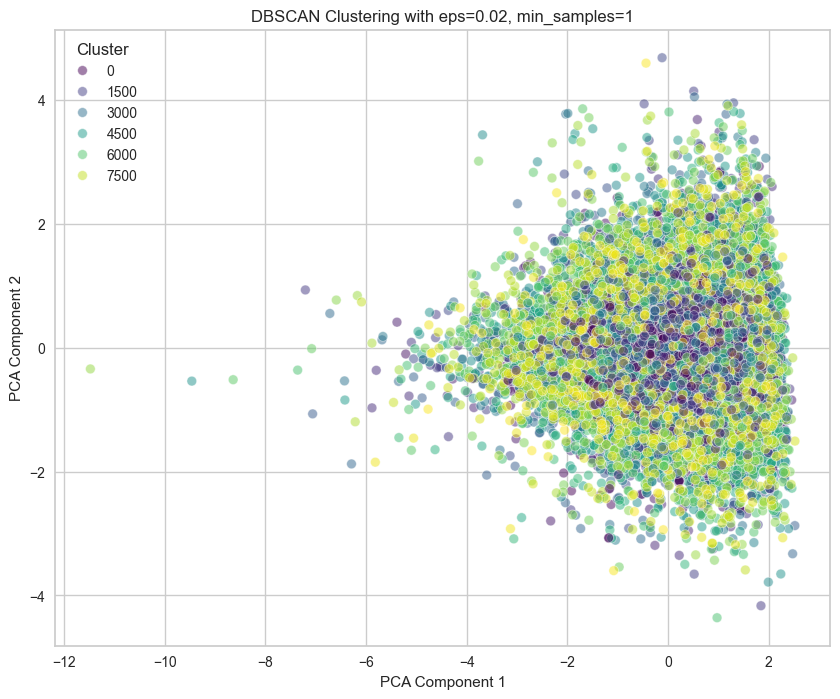

In [13]:
def dbscan_silhouette_score(data, eps, min_samples):
    dbscan = DBSCAN(eps = eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    if len(set(labels)) > 1 and -1 not in labels:
        score = silhouette_score(data, labels)
    else:
        score = -1
    return score, labels

eps_values = np.arange(0.005, 0.1, 0.005)
mins_samples_values = range(1,10)
best_params = None
best_silhouette = -1
best_labels = None

for eps, min_samples in product(eps_values, mins_samples_values):
    score, labels = dbscan_silhouette_score(pca_features_sampled, eps, min_samples)
    if score > best_silhouette:
        best_silhouette = score
        best_params = (eps, min_samples)
        best_labels = labels

if best_params:
    best_eps, best_min_samples = best_params
    print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples} with Silhouette Score: {best_silhouette}")

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=pca_features_sampled[:, 0], y=pca_features_sampled[:, 1], hue=best_labels, palette='viridis', alpha=0.5)
    plt.title(f'DBSCAN Clustering with eps={best_eps}, min_samples={best_min_samples}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

else:
    print("No valid DBSCAN clustering found within the given parameter range.")

#### MKDN for obs

#### Now that we know what our optimized parameters are, let's look at the silhouette plots themselves.

In [ ]:
def dbscan_silhouette_visualizer(data, eps, min_samples):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    labels = dbscan.fit_predict(data)
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    visualizer = SilhouetteVisualizer(dbscan, ax = ax, colors = 'yellowbrick')
    visualizer.fit(data)
    visualizer.show()

dbscan_silhouette_visualizer(dbscan_scaled, best_eps, best_min_samples)

#### MKDN for obs

#### Let's now look at a cluster analysis, looking at specific details about each cluster to get more information out of them before we move along.

In [ ]:
dbscan_scaled['Cluster'] = best_labels
cluster_labels = dbscan_scaled['Cluster'].value_counts()
print("\nCluster counts:")
print(cluster_labels)

silhouette_avg = silhouette_score(dbscan_scaled.drop('Cluster', axis=1), best_labels)
print(f'Silhouette Score for best parameters: {silhouette_avg}')

for cluster in set(best_labels):
    cluster_data = dbscan_scaled[dbscan_scaled['Cluster'] == cluster]
    print(f'\nCluster {cluster} statistics:')
    print(cluster_data.describe())

def silhouette_per_cluster(data, labels):
    cluster_silhouette = {}
    for cluster in set(labels):
        if cluster != -1:
            cluster_data = data[labels == cluster]
            score = silhouette_score(cluster_data, [cluster] * len(cluster_data))
            cluster_silhouette[cluster] = score
    return cluster_silhouette

cluster_silhouette_scores = silhouette_per_cluster(dbscan_scaled.drop('Cluster', axis=1), best_labels)
print(f'Cluster Silhouette Scores: {cluster_silhouette_scores}')



#### MKDN for obs

#### And now let's look at some pairplots and histograms for each cluster to see what relationships lie within.

In [ ]:
def dbscan_pairplot(data, clusters):
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        pair_plot = sns.pairplot(cluster_data, palette='viridis')
        pair_plot.fig.suptitle(f'Pair Plot for Cluster {cluster}', y=1.02, fontsize=16)
        pair_plot.fig.tight_layout()
        plt.show()

dbscan_pairplot(dbscan_scaled, set(best_labels))

In [ ]:
def plot_cluster_histograms(data, clusters):
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        plt.figure(figsize=(10, 6))
        sns.histplot(cluster_data.drop(columns='Cluster'), kde=True, palette='viridis', multiple='stack')
        plt.title(f'Population Dispersion for Cluster {cluster}')
        plt.xlabel('Features')
        plt.ylabel('Count')
        plt.show()

plot_cluster_histograms(dbscan_scaled, set(best_labels))

#### MKDN for obs (choose a cluster here)

In [ ]:
best_cluster_data = dbscan_scaled[dbscan_scaled['Cluster'] == ]


#### Now we will remove any outliers from the data before we move on.  Outliers are treated and addressed differently in DBSCAN, as you can't just removed a fixed value.

In [ ]:
outliers = dbscan_scaled[dbscan_scaled['Cluster'] == -1]
print(f'Number of outliers: {len(outliers)}')

dbscan_scaled_no_outliers = dbscan_scaled[dbscan_scaled['Cluster'] != -1]

#### We will now render a 3D plot of our cluster to see how it looks.

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = best_cluster_data.iloc[:, 0]
y = best_cluster_data.iloc[:, 1]
z = best_cluster_data.iloc[:, 2]

scatter = ax.scatter(x, y, z, c=best_cluster_data['Cluster'], cmap='viridis', marker='o')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.title(f'3D Scatter plot of Best Cluster (Cluster {best_cluster_label})')
plt.show()

#### MKDN for OBS

#### Finally let's look at the centroids themselves with a heatmap and a bar plot.

In [ ]:
cluster_centroids = dbscan_scaled_no_outliers.groupby('Cluster').mean()
print("Cluster Centroids:")
print(cluster_centroids)

In [ ]:
cluster_centroids.T.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster Centroids Comparison')
plt.ylabel('Feature Mean')
plt.xlabel('Features')
plt.legend(title='Cluster')
plt.savefig('cluster_centroids_bar_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_centroids.T, annot=True, cmap='viridis')
plt.title('Cluster Centroids Heatmap')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.savefig('cluster_centroids_heatmap.png')
plt.show()

#### MKDN for Obs

#### We will now conclude this notebook with a short summary below of our findings.

In [ ]:
print("\nDBSCAN clustering analysis completed.")
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples} with Silhouette Score: {best_silhouette}")
print(f"Number of clusters found: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")
print(f"Number of outliers: {len(outliers)}")